In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange

In [4]:
df = pd.read_csv('CNRPark+EXT.csv')
df.head()

,camera,datetime,day,hour,image_url,minute,month,occupancy,slot_id,weather,year,occupant_changed
0,A,20150703_0805,3,8,CNRPark/A/free/20150703_0805_1.jpg,5,7,0,1,S,2015,NaN
1,A,20150703_0810,3,8,CNRPark/A/free/20150703_0810_1.jpg,10,7,0,1,S,2015,NaN
2,A,20150703_0815,3,8,CNRPark/A/busy/20150703_0815_1.jpg,15,7,1,1,S,2015,0.0
3,A,20150703_0820,3,8,CNRPark/A/busy/20150703_0820_1.jpg,20,7,1,1,S,2015,0.0
4,A,20150703_0825,3,8,CNRPark/A/busy/20150703_0825_1.jpg,25,7,1,1,S,2015,0.0


In [7]:
PATH = os.path.abspath(os.getcwd())
PATH

'/home/ademattos/carNocar'

In [8]:
class CNRParkDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.images = os.listdir(root_dir)
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.root_dir))
    
    def __getitem__(self, index):
        img_loc = os.path.join(self.root_dir,self.images[index])
        img = Image.open(img_loc).convert("RGB")
        label = 1 if os.path.basename(self.root_dir) == 'busy' else 0
        
        if self.transform is not None:
            img = self.transform(img)
#             img = img.reshape((3,150,150))
    
        return img,label
        

In [9]:
tfms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((150,150)),
    torchvision.transforms.ToTensor()])
aBusyDset = CNRParkDataset(PATH+'/A/busy', transform=tfms)
aFreeDset = CNRParkDataset(PATH+'/A/free', transform=tfms)
bBusyDset = CNRParkDataset(PATH+'/B/busy', transform=tfms)
bFreeDset = CNRParkDataset(PATH+'/B/free', transform=tfms)

In [10]:
img,label = aBusyDset.__getitem__(0)
img.shape, label

(torch.Size([3, 150, 150]), 1)

In [11]:
concat_dataset = torch.utils.data.ConcatDataset([aBusyDset,aFreeDset,bBusyDset,bFreeDset])
train_loader = DataLoader(concat_dataset,batch_size=64,shuffle=True)
len(concat_dataset)

12584

In [12]:
train_iter = iter(train_loader)
images,labels = train_iter.next()
images.size(),labels.size()

(torch.Size([64, 3, 150, 150]), torch.Size([64]))

Text(0.5, 1.0, 'tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,\n        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,\n        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0])')

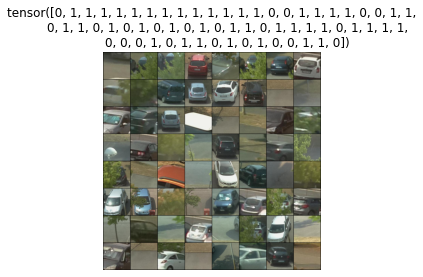

In [13]:
grid = torchvision.utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
plt.title(labels)

In [14]:

#model
class ApdNet(torch.nn.Module):
    def __init__(self):
        super(ApdNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(87616, 1000)
        self.fc2 = nn.Linear(1000, 2)
    def forward(self,x):
        #Max pooling over (2,2) window
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Epoch [5/5], Step [197,197], Loss: 0.0228, Accuracy: 100.00%: 100%|██████████| 5/5 [09:48<00:00, 117.67s/it]


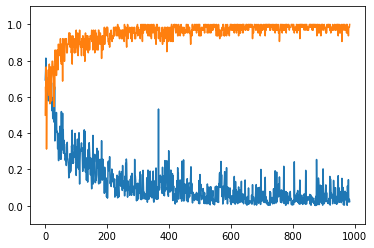

In [22]:

model = ApdNet()

loss_list, acc_list = [],[]
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 5
total_step = len(train_loader)
for epoch in (t := trange(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_func(outputs,labels)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
#         print(outputs.data)
#         print(predicted)
#         print(labels)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct/total)
        
        t.set_description('Epoch [{}/{}], Step [{},{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                       (correct/total)*100))
    
plt.ylim(-0.1,1.1)
plt.plot(loss_list)
plt.plot(acc_list)

In [26]:
model.eval()
img = Image.open(PATH+'/test_images/no_car3.png').convert("RGB")
img = torchvision.transforms.functional.resize(img, (150,150))
img = torchvision.transforms.functional.to_tensor(img)
img = img.unsqueeze(0)
print(img.shape)
with torch.no_grad():
    output = model(img)
output


torch.Size([1, 3, 150, 150])


tensor([[ 4.8462, -4.8532]])